<a href="https://colab.research.google.com/github/Aaron9318/ResearchProject/blob/main/Resnet/Resnet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import time
import numpy as np
import torch
from torch.utils.data import DataLoader
#from torchvision import datasets
#from torchvision import transforms
import glob, os
from tqdm import tqdm
import torchvision
#State the main folder to read the files is located here
#os.chdir(r"/content/drive/MyDrive/ResearchProject/Data")
os.chdir(r"C:\Users\demon\Documents\Maestria y Papeles Alemania\ResearchProject\datos\Data")

In [3]:
from collections import defaultdict
from functools import partial
from multiprocessing import cpu_count
from pathlib import Path
from textwrap import dedent

In [4]:
import itertools 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import joblib
#import sklearn.externals 
#from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader


In [5]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

In [6]:


def plot_confusion_matrixes(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## DatasetReadingoneclass


In [7]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 50
#DEVICE = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [8]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [9]:
import h5py

with h5py.File(r"dataBaselinecut100.h5", "r") as f:
#with h5py.File(r"dataBaselinecut1000.h5", "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])




Keys: <KeysViewHDF5 ['EEG']>


In [10]:
with h5py.File(r"binomialclass.h5", "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    wayu = list(f[a_group_key])

Keys: <KeysViewHDF5 ['class']>


In [11]:
raw_arr = np.array(data)
target = np.array(wayu)
print(raw_arr.shape)
print(target.shape)


(109463, 450, 11)
(109463,)


In [12]:
values, counts =  np.unique(target, return_counts=True)
itemindex = np.where(target == 0)
itemindex1 = np.where(target == 1)

valmin =  min(counts)
valmax =  max(counts)
dif =  valmax-valmin
b =  np.random.choice(itemindex1[0],dif,replace=False)


In [13]:

raw_arr = np.delete(raw_arr, b, axis=0)
target = np.delete(target,b, axis = 0)
print(raw_arr.shape)
print(target.shape)


(65346, 450, 11)
(65346,)


In [14]:
raw_arr =  raw_arr.transpose(0,2,1)
print(raw_arr.shape)



(65346, 11, 450)


In [15]:
def create_datasets(data, target, train_size, valid_pct=0.1, seed=None):
    """Converts NumPy arrays into PyTorch datsets.
    
    Three datasets are created in total:
        * training dataset
        * validation dataset
        * testing (un-labelled) dataset

    """
    #raw, fft = data
    #assert len(raw) == len(fft)
    raw = data
    sz = train_size
    idx = np.arange(sz)
    trn_idx, val_idx = train_test_split(
        idx, test_size=valid_pct, random_state=RANDOM_SEED)
    trn_ds = TensorDataset(
        torch.tensor(raw[:sz][trn_idx]).float(), 
        #torch.tensor(fft[:sz][trn_idx]).float(), 
        torch.tensor(target[:sz][trn_idx]).long())
    val_ds = TensorDataset(
        torch.tensor(raw[:sz][val_idx]).float(), 
        #torch.tensor(fft[:sz][val_idx]).float(), 
        torch.tensor(target[:sz][val_idx]).long())
    tst_ds = TensorDataset(
        torch.tensor(raw[sz:]).float(), 
        #torch.tensor(fft[sz:]).float(), 
        torch.tensor(target[sz:]).long())
    return trn_ds, val_ds, tst_ds

In [16]:
def create_loaders(data, bs=128, jobs=0):
    """Wraps the datasets returned by create_datasets function with data loaders."""
    
    trn_ds, val_ds, tst_ds = data
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=jobs)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    return trn_dl, val_dl, tst_dl


In [17]:
raw_feat = raw_arr.shape[1]
print(raw_feat)

11


In [18]:
trn_sz = round(len(raw_arr)*.7)
 # only the first `trn_sz` rows in each array include labelled data
datasets = create_datasets(raw_arr,target, trn_sz, seed=RANDOM_SEED)
trn_da, val_da, tst_da = datasets
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



In [19]:
#raw_feat = raw_arr.shape[2]
#fft_feat = fft_arr.shape[1]

trn_dl, val_dl, tst_dl = create_loaders(datasets,bs=256)

In [20]:
torch.cuda.is_available()


True

## ReadDatasets


In [7]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 50

In [8]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [9]:
import h5py


with h5py.File(r"dataBaselinecut100.h5", "r") as f:
#with h5py.File(r"dataBaselinecut1000.h5", "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])




Keys: <KeysViewHDF5 ['EEG']>


In [10]:
with h5py.File(r"multiclass.h5", "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    wayu = list(f[a_group_key])

Keys: <KeysViewHDF5 ['class']>


In [11]:
raw_arr = np.array(data)
target = np.array(wayu)
print(raw_arr.shape)
print(target.shape)
values, counts =  np.unique(target, return_counts=True)
print(values,counts)


(109463, 450, 11)
(109463,)
[0. 1. 2. 3.] [76790 21701  3422  7550]


In [12]:
#Erasing classes 
itemindex1 = np.where(target == 0)
itemindex2 = np.where(target == 1)
itemindex3 = np.where(target == 3)

small =  counts[2]

big1 = counts[0]
big2 = counts[1]
big3 = counts[3]

dif1 =  big1-small
dif2 =  big2-small
dif3 = big3-small

b =  np.random.choice(itemindex1[0],dif1,replace=False)
b1 =  np.random.choice(itemindex2[0],dif2,replace=False)
b2 =  np.random.choice(itemindex3[0],dif3,replace=False)
br = np.concatenate((b,b1,b2),0)

In [13]:
raw_arr = np.delete(raw_arr, br, axis=0)
target  = np.delete(target, br, axis=0)
values, counts =  np.unique(target, return_counts=True)
print(values,counts)


[0. 1. 2. 3.] [3422 3422 3422 3422]


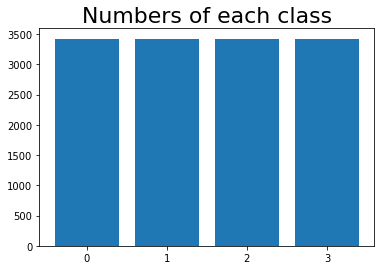

In [14]:
import matplotlib.pyplot as plt

plt.bar(values,counts)
plt.xticks(values)
plt.title('Numbers of each class', fontsize= 22)
#plt.savefig('Classes  ')
plt.show()


In [15]:
raw_arr =  raw_arr.transpose(0,2,1)
print(raw_arr.shape)
print(target.shape)


(13688, 11, 450)
(13688,)


In [16]:
def create_datasets(data, target, train_size, valid_pct=0.1, seed=None):
    """Converts NumPy arrays into PyTorch datsets.
    
    Three datasets are created in total:
        * training dataset
        * validation dataset
        * testing (un-labelled) dataset

    """
    #raw, fft = data
    #assert len(raw) == len(fft)
    raw = data
    sz = train_size
    idx = np.arange(sz)
    trn_idx, val_idx = train_test_split(
        idx, test_size=valid_pct, random_state=RANDOM_SEED)
    trn_ds = TensorDataset(
        torch.tensor(raw[:sz][trn_idx]).float(), 
        #torch.tensor(fft[:sz][trn_idx]).float(), 
        torch.tensor(target[:sz][trn_idx]).long())
    val_ds = TensorDataset(
        torch.tensor(raw[:sz][val_idx]).float(), 
        #torch.tensor(fft[:sz][val_idx]).float(), 
        torch.tensor(target[:sz][val_idx]).long())
    tst_ds = TensorDataset(
        torch.tensor(raw[sz:]).float(), 
        #torch.tensor(fft[sz:]).float(), 
        torch.tensor(target[sz:]).long())
    return trn_ds, val_ds, tst_ds

In [17]:
def create_loaders(data, bs=128, jobs=0):
    """Wraps the datasets returned by create_datasets function with data loaders."""
    
    trn_ds, val_ds, tst_ds = data
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=jobs)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    return trn_dl, val_dl, tst_dl


In [18]:
raw_feat = raw_arr.shape[1]
print(raw_feat)

11


In [19]:
trn_sz = round(len(raw_arr)*.7)
 # only the first `trn_sz` rows in each array include labelled data
datasets = create_datasets(raw_arr,target, trn_sz, seed=RANDOM_SEED)
#trn_da, val_da, tst_da = create_datasets(alfa,beta, trn_sz, seed=RANDOM_SEED)

#This line selects the device you want to use for computing 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



In [20]:
#raw_feat = raw_arr.shape[2]
#fft_feat = fft_arr.shape[1]

trn_dl, val_dl, tst_dl = create_loaders(datasets,bs=256)

In [21]:
torch.cuda.is_available()


True

# Model

In [22]:

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return torch.nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return torch.nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(torch.nn.Module):
    expansion: int = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm1d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(torch.nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion=4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm1d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = torch.nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(torch.nn.Module):

    def __init__(self, block, layers, num_classes, zero_init_residual=False, groups=1,
                 width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm1d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = torch.nn.Conv1d(11, self.inplanes, kernel_size=7, stride=2, padding=3,
                                     bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = torch.nn.AdaptiveAvgPool1d(1)
        self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv1d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (torch.nn.BatchNorm1d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    torch.nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    torch.nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks,
                    stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# OwnResnet


In [35]:
# class ResidualBlock(torch.nn.Module):
#     """ Helper Class"""

#     def __init__(self, channels):
        
#         super(ResidualBlock, self).__init__()
        
#         self.block = nn.Sequential(
#                 nn.Conv1d(in_channels=channels[0],
#                                 out_channels=channels[1],
#                                 kernel_size=3,
#                                 stride=2,
#                                 padding=1),
#                 nn.BatchNorm1d(channels[1]),
#                 nn.ReLU(inplace = True),
#                 nn.Conv1d(in_channels=channels[1],
#                                 out_channels=channels[2],
#                                 kernel_size=1,
#                                 stride=1,
#                                 padding=0),   
#                 nn.BatchNorm1d(channels[2])
#         )

#         self.shortcut = nn.Sequential(
#                 nn.Conv1d(in_channels=channels[0],
#                                 out_channels=channels[2],
#                                 kernel_size=1,
#                                 stride=2,
#                                 padding=0),
#                 nn.BatchNorm1d(channels[2])
#         )
            
#     def forward(self, x):
#         shortcut = x
#         block = self.block(x)
#         shortcut = self.shortcut(x)    
#         x = F.relu(block+shortcut)

#         return x

In [36]:
# class Classifier(nn.Module):
#     def __init__(self, raw_ni, no, drop=.5):
#         super(Classifier,self).__init__()

#         self.conv1 = nn.Conv1d(in_channels=raw_ni, out_channels=16, kernel_size=3, padding=2)
#         self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2)
#         #256, 16, 226


#         self.res1 = ResidualBlock(channels=[16, 20, 24])
#         self.res2 = ResidualBlock(channels=[24, 28, 32])
#         self.res3 = ResidualBlock(channels=[32, 36, 40])
#         self.res4 = ResidualBlock(channels=[40, 44, 48])
#         self.res5 = ResidualBlock(channels=[48, 52, 56])
        
#         self.avgpool = nn.AvgPool1d(kernel_size=2, stride=2, padding = 1)

#         #self.flats = Flatten()

#         self.fc1 = nn.Linear(280,140)
#         self.fc2 = nn.Linear(140,no)
#         #self.fc3 = nn.Linear(70,35)
#         #self.fc4 = nn.Linear(35,no)
  
#     def forward(self,x):

#         x = F.relu(self.conv1(x))
#         x = (self.maxpool(x))

#         x = self.res1(x)
#         x = self.res2(x)
#         x = self.res3(x)
#         x = self.res4(x)
#         x = self.res5(x)
    
#         x = self.avgpool(x)
  	    
#         x = torch.flatten(x, 1)
#         #x = self.flats(x)
#         #x = x.flatten(1) # flatten the tensor starting at dimension 1

#         x = F.relu(self.fc1(x))
#         #x = F.relu(self.fc2(x))
#         #x = F.relu(self.fc3(x))
#         x = self.fc2(x)

#         return x

    

In [37]:
class ResidualBlock(torch.nn.Module):
    """ Helper Class"""

    def __init__(self, channels):
        
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
                nn.Conv1d(in_channels=channels[0],
                                out_channels=channels[1],
                                kernel_size=3,
                                stride=2,
                                padding=1),
                nn.BatchNorm1d(channels[1]),
                nn.ReLU(inplace = True),
                nn.Conv1d(in_channels=channels[1],
                                out_channels=channels[2],
                                kernel_size=1,
                                stride=1,
                                padding=0),   
                nn.BatchNorm1d(channels[2])
        )

        self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels=channels[0],
                                out_channels=channels[2],
                                kernel_size=1,
                                stride=2,
                                padding=0),
                nn.BatchNorm1d(channels[2])
        )
            
    def forward(self, x):
        shortcut = x
        block = self.block(x)
        shortcut = self.shortcut(x)    
        x = F.relu(block+shortcut)

        return x

In [38]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, no, drop=.5):
        super(Classifier,self).__init__()

        self.conv1 = nn.Conv1d(in_channels=raw_ni, out_channels=16, kernel_size=3, padding=2)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2)
        #256, 16, 226


        self.res1 = ResidualBlock(channels=[16, 20, 24])
        self.res2 = ResidualBlock(channels=[24, 28, 32])
        self.res3 = ResidualBlock(channels=[32, 36, 40])
        self.res4 = ResidualBlock(channels=[40, 44, 48])
        self.res5 = ResidualBlock(channels=[48, 52, 56])
        
        self.avgpool = nn.AvgPool1d(kernel_size=2, stride=2, padding = 1)

        self.flats = Flatten()

        self.liner = nn.Sequential(
            nn.Dropout(drop),nn.Linear(280,140), nn.PReLU(), nn.BatchNorm1d(140),
            nn.Dropout(drop),nn.Linear(140,70),nn.PReLU(),nn.BatchNorm1d(70))
        
        self.Out = nn.Sequential(
            nn.Linear(70,35), nn.ReLU(inplace=True), nn.Linear(35, no))
        
        
        #self.fc1 = nn.Linear(280,140)
        #self.fc2 = nn.Linear(140,no)
        #self.fc3 = nn.Linear(70,35)
        #self.fc4 = nn.Linear(35,no)
  
    def forward(self,x):

        x = F.relu(self.conv1(x))
        x = (self.maxpool(x))

        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
    
        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        #x = self.flats(x)

        
        x = self.liner(x)
        x = self.Out(x)

        return x

    

# Simple CNN


In [22]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:        
            return x.view(x.size(0), -1)
        return x.view(-1)

In [23]:
class Classifier1(nn.Module):
    def __init__(self, raw_ni, no, drop=.5):
        super().__init__()


       
        # [B, C1, 450]
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2)
        
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2,padding=1)
        
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=3)
        
      
        self.conv1 = nn.Conv1d(in_channels=raw_ni, out_channels=11, kernel_size=3, padding=2)   
        self.conv2 = nn.Conv1d(11,10, kernel_size=3, padding=2)
        self.conv3 = nn.Conv1d(10,9, kernel_size=3, padding=3)
        self.conv4 = nn.Conv1d(9,8, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(8,7, kernel_size=3, padding=1)
        self.conv6 = nn.Conv1d(7,6, kernel_size=3, padding=1)
        


        self.Flat =  Flatten()
        # [B, C2, 6]
        self.fc1 = nn.Linear(36,18)
        # [B, F1]
        self.fc2 = nn.Linear(18,9)
        # [B, F2]
        self.fc3 = nn.Linear(9,no)
        #
        #self.fc4 = nn.Linear(36,18)
        #
        #self.fc5 = nn.Linear(18,no)
        # [B, 2]

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = (self.maxpool(x))

        x = F.relu(self.conv2(x))
        x = self.maxpool1(x)
        
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
      
        x = F.relu(self.conv4(x))
        x = self.maxpool1(x)
        
        x = F.relu(self.conv5(x))
        x = self.maxpool2(x)
        
        x = F.relu(self.conv6(x))
        x = self.maxpool1(x)

        x = self.Flat(x)
        #x = x.flatten(1) # flatten the tensor starting at dimension 1

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x) 
        #x = F.relu(self.fc4(x))
        #x = self.fc5(x)
        return x

    

# Training

In [23]:
model = ResNet(BasicBlock, layers=[3, 4, 6, 3], num_classes=4)
#model = Classifier1(raw_feat,no = 4) # ResNet34
#model = Classifier(raw_feat,no = 4) # ResNet34

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
model = model.to(device)

optimizer = optim.Adam(model.parameters(),lr = 0.01)
criterion = nn.CrossEntropyLoss(reduction='sum')
#optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

Epoch: 001/050 | Batch 0000/0034 | Loss: 361.1354
Epoch: 001/050 | Train: 39.12% | Validation: 33.99% | New model saved
Time elapsed: 0.34 min
Epoch: 002/050 | Batch 0000/0034 | Loss: 323.9802
Epoch: 002/050 | Train: 48.01% | Validation: 45.67% | New model saved
Time elapsed: 0.68 min
Epoch: 003/050 | Batch 0000/0034 | Loss: 291.3418
Epoch: 003/050 | Train: 46.07% | Validation: 41.81%
Time elapsed: 1.02 min
Epoch: 004/050 | Batch 0000/0034 | Loss: 296.5759
Epoch: 004/050 | Train: 54.75% | Validation: 50.05% | New model saved
Time elapsed: 1.35 min
Epoch: 005/050 | Batch 0000/0034 | Loss: 275.9518
Epoch: 005/050 | Train: 63.45% | Validation: 59.44% | New model saved
Time elapsed: 1.69 min
Epoch: 006/050 | Batch 0000/0034 | Loss: 241.4939
Epoch: 006/050 | Train: 62.28% | Validation: 60.79% | New model saved
Time elapsed: 2.03 min
Epoch: 007/050 | Batch 0000/0034 | Loss: 225.4471
Epoch: 007/050 | Train: 66.82% | Validation: 62.98% | New model saved
Time elapsed: 2.37 min
Epoch: 008/050 | 

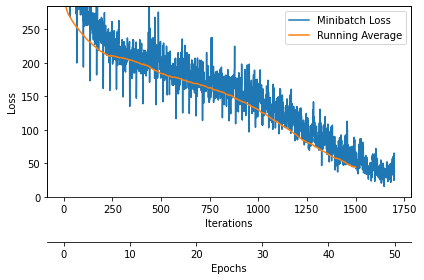

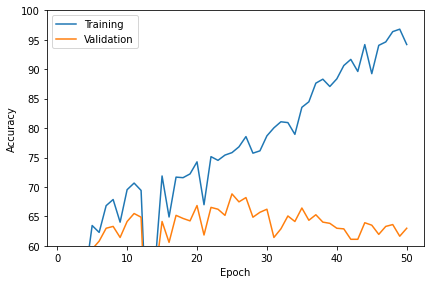

In [25]:
model = ResNet(BasicBlock, layers=[3, 4, 6, 3], num_classes=4)
#model = Classifier1(raw_feat,no = 4) # ResNet34
#model = Classifier(raw_feat,no = 4) # ResNet34

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
model = model.to(device)

optimizer = optim.Adam(model.parameters(),lr = 0.01)
criterion = nn.CrossEntropyLoss(reduction='sum')
#optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=trn_dl,
    valid_loader=val_dl,
    test_loader=tst_dl,
    criterion = criterion,
    optimizer=optimizer,
    path = r'Resnet34/CNN.pth',
    device=device,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(trn_dl),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

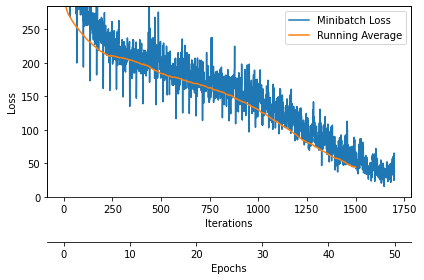

In [26]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(trn_dl),
                   results_dir=None,
                   averaging_iterations=200)

plt.savefig(r'Resnet34/Lossmulticlass')
plt.show()




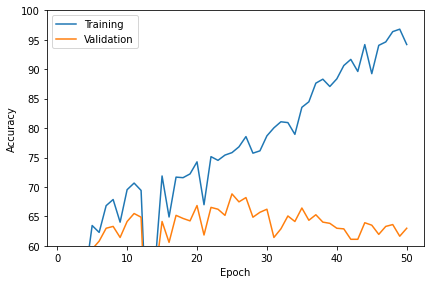

In [27]:
plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.savefig(r'Resnet34/Accuraccymulticlass')
plt.show()

# Plots

In [32]:

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
model.cpu()
device=torch.device('cpu')
test_results = []
test_results1 = []
model.load_state_dict(torch.load(r'Resnet34/CNN.pth'))
model.eval()
correct, total = 0, 0
for batch in tst_dl:
      x_raw, y_batch = [t.to(device) for t in batch]
      out = model(x_raw)
      y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
      total += y_batch.size(0)
      correct += (y_hat == y_batch).sum().item()
      test_results.extend(y_batch.tolist())
      test_results1.extend((y_hat.tolist()))
    

targ = torch.tensor(test_results)
preds = torch.tensor(test_results1)
cm = confusion_matrix(targ,preds)
print(cm)



[[767  85  79  67]
 [177 773 135 206]
 [ 82 163 527 113]
 [133 154 143 502]]


In [28]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


from sklearn.metrics import confusion_matrix

In [30]:
#model = ResNet(BasicBlock, layers=[3, 4, 6, 3], num_classes=4)
test_results = []
test_results1 = []
model.load_state_dict(torch.load(r'Resnet34/CNN.pth'))
model.eval()
correct, total = 0, 0
for batch in val_dl:
      x_raw, y_batch = [t.to(device) for t in batch]
      out = model(x_raw)
      y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
      total += y_batch.size(0)
      correct += (y_hat == y_batch).sum().item()
      test_results.extend(y_batch.tolist())
      test_results1.extend((y_hat.tolist()))
    

RuntimeError: ignored

In [43]:


Tutal =  pd.DataFrame([test_results,test_results1])

In [33]:
targ = torch.tensor(test_results)
preds = torch.tensor(test_results1)
cm = confusion_matrix(targ,preds)
print(cm)
#labes = ['Bad','Good']
labes = ['Uncorrected','Rejected','Move','Blink']

[[767  85  79  67]
 [177 773 135 206]
 [ 82 163 527 113]
 [133 154 143 502]]


Normalized confusion matrix
[[0.76853707 0.08517034 0.07915832 0.06713427]
 [0.13710302 0.59876065 0.1045701  0.15956623]
 [0.09265537 0.18418079 0.59548023 0.12768362]
 [0.14270386 0.16523605 0.15343348 0.53862661]]


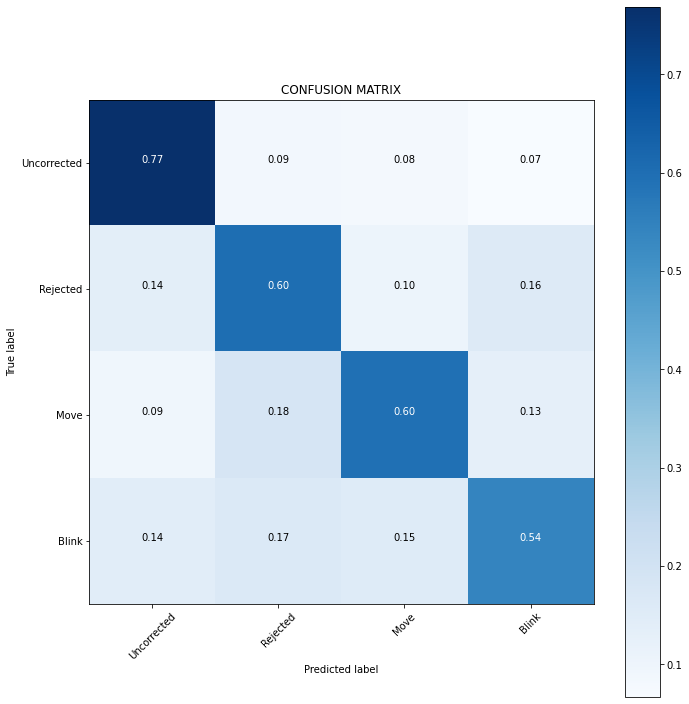

In [34]:
plt.figure(figsize=(10,10))
plot_confusion_matrixes(cm, labes, normalize=True)
plt.title('CONFUSION MATRIX')
plt.savefig(r'Resnet34/evenclasses')
plt.show()

[0.69393382 0.62211422 0.58849315 0.53501722]


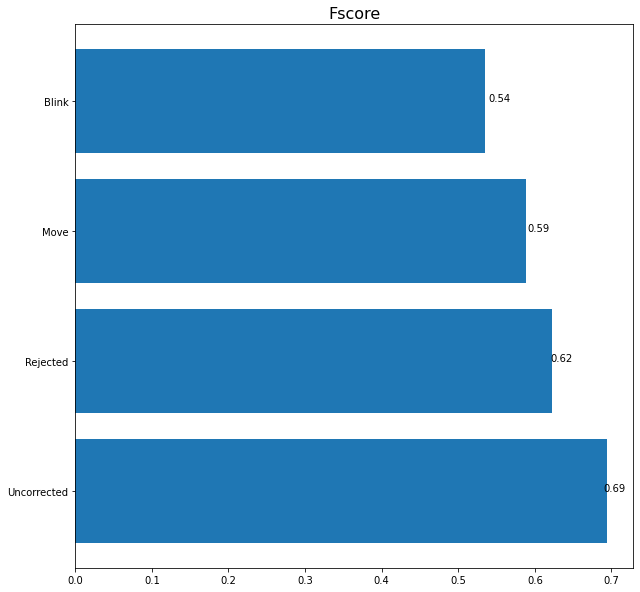

In [46]:
from sklearn.metrics import f1_score
fsore = f1_score(targ,preds , average=None)
plt.figure(figsize=(10,10))
plt.barh(labes,fsore)
for index, value in enumerate(fsore):
    plt.text(round(value,2), index, str(round(value,2)))
    
plt.rc('figure', titlesize=48)  # fontsize of the figure title

plt.yticks(values)
plt.title('Fscore',fontsize=16)
plt.savefig(r'OwnResnet/FscoreEvenClass')
print(fsore)

In [ ]:
# import itertools
# class_dict = {0: 'wrong',
#               1: 'good'}

# plt.figure(figsize=(10,10))
# plot_confusion_matrixes(cm, class_dict.values(), normalize=True)
# plt.title('CONFUSION MATRIX')
# plt.savefig(r'ResnetResults/Confusion Matrix Multiple %')
# plt.show()

# fsore = f1_score(targ,preds , average=None)
# plt.bar(list(class_dict.values()),fsore)
# plt.rc('figure', titlesize=48)  # fontsize of the figure title
# plt.xticks(list(class_dict.values()))
# plt.title('Fscore',fontsize=16)
# plt.savefig(r'ResnetResults/Fscore')
# plt.show()
# print(fsore)

